In [2]:
cd ..

/home/amiyaguchi/cs224w/wikipedia-retention


In [3]:
from pyspark.sql import SparkSession, functions as F, types as T

spark = SparkSession.builder.getOrCreate()
enmain = spark.read.parquet("data/interim/enwiki-meta-main")
enmain.createOrReplaceTempView("enmain")

In [4]:
enmain.show(n=5, vertical=True, truncate=False)

-RECORD 0--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 article_id    | 8807453                                                                                                                                                                                                                                               
 rev_id        | 99128362                                                                                                                                                                                                                                              
 article_title | Chrysolaminarin                                                                                                                                                                                

In [9]:
article_sample = set(
    map(lambda x: x.article_id, (
            enmain
            .groupBy("article_id")
            .agg(F.count("*").alias("n_edits"))
            .where("n_edits > 10 and n_edits < 50")
            .orderBy(F.rand())
            .take(1000)
        )))

In [12]:
sample = enmain.where(F.col("article_id").isin(article_sample))
sample.cache()
sample.count()

23143

- How many times are they referenced in main? In user/talk?
- Distribution of article edits (by count, by textdata)
- Distribution of article age
- Are the user references increasing? Can we create a diff?
- Which is the canonical reference to time? Revision or timestamp?

In [54]:
rev_history = (
    sample
    .select("article_id", 
            "rev_id", 
            "timestamp", 
            "article_title", 
            "main")
    .orderBy("article_id", "rev_id")
)

rev_history.show(n=3, vertical=True, truncate=False)
rev_history.createOrReplaceTempView("rev_history")

-RECORD 0---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 article_id    | 18558                                                                                                                                                                                                                 

In [138]:
from pyspark.sql.window import Window

previous_rev = Window.partitionBy("article_id").orderBy("rev_id")

diffs = (
    revhistory
    .select("article_id", "rev_id", "article_title", "timestamp", F.size("main").alias("refs"))
    .withColumn("diff", F.col("refs") - F.lag("refs").over(previous_rev))
)
diffs.show()

+----------+--------+---------------+-------------------+----+----+
|article_id|  rev_id|  article_title|          timestamp|refs|diff|
+----------+--------+---------------+-------------------+----+----+
|   2029502|15059829|Per-Olov_Löwdin|2005-06-12 02:07:33|   4|null|
|   2029502|15070286|Per-Olov_Löwdin|2005-06-12 02:19:44|   7|   3|
|   2029502|17645885|Per-Olov_Löwdin|2005-06-12 08:50:42|   7|   0|
|   2029502|18626082|Per-Olov_Löwdin|2005-07-11 13:59:21|   7|   0|
|   2029502|19075949|Per-Olov_Löwdin|2005-07-18 05:30:43|   8|   1|
|   2029502|19798880|Per-Olov_Löwdin|2005-07-28 11:14:38|   8|   0|
|   2029502|20948757|Per-Olov_Löwdin|2005-08-13 14:32:56|  12|   4|
|   2029502|23049120|Per-Olov_Löwdin|2005-09-11 11:01:25|  16|   4|
|   2029502|27810111|Per-Olov_Löwdin|2005-11-09 03:01:27|  16|   0|
|   2029502|36308025|Per-Olov_Löwdin|2006-01-22 19:25:43|  16|   0|
|   2029502|40685718|Per-Olov_Löwdin|2006-02-21 23:57:03|  16|   0|
|   2029502|42958835|Per-Olov_Löwdin|2006-03-09 

In [192]:
revhistory.withColumn("out_of_order", F.col("timestamp") < F.lag("timestamp").over(previous_rev)).where("out_of_order").collect()

[Row(article_id=60683, rev_id=110971, timestamp=datetime.datetime(2002, 7, 6, 1, 14, 10), article_title='Reality_enforcement', main=['A_priori', 'Consensus_reality', 'Idealism', 'Reality', 'Anti-psychiatry', 'Involuntary_commitment', 'Theory'], out_of_order=True),
 Row(article_id=18558, rev_id=265008, timestamp=datetime.datetime(2001, 12, 11, 12, 26, 53), article_title='Latin_music', main=None, out_of_order=True)]

In [193]:
prev_timestamp = Window.partitionBy("article_id").orderBy("timestamp")
revhistory.withColumn("out_of_order", F.col("rev_id") < F.lag("rev_id").over(prev_timestamp)).where("out_of_order").collect()

[Row(article_id=60683, rev_id=58542, timestamp=datetime.datetime(2002, 7, 8, 4, 16, 5), article_title='Reality_enforcement', main=['A_priori', 'Consensus_reality', 'Idealism', 'Reality', 'Anti-psychiatry', 'Delusion', 'Involuntary_commitment', 'Theory'], out_of_order=True),
 Row(article_id=18558, rev_id=99868, timestamp=datetime.datetime(2002, 2, 25, 7, 51, 15), article_title='Latin_music', main=['Rock_en_espanol', 'Banda'], out_of_order=True)]

In [134]:
import matplotlib.pyplot as plt

max_size = spark.sql("""
select
    article_id,
    max(size(main)) as max_size
from rev_history
where main is not null
group by 1
order by 2 desc
""")

max_size.show(n=5)
dist = max_size.groupby("max_size").count().toPandas()

+----------+--------+
|article_id|max_size|
+----------+--------+
|    655357|    2422|
|    209735|     677|
|   1204658|     288|
|   9303959|     248|
|   1254664|     220|
+----------+--------+
only showing top 5 rows



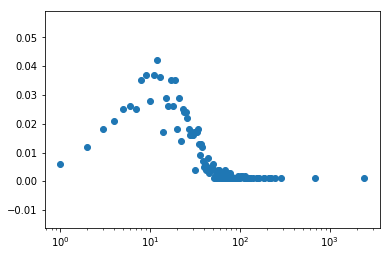

In [126]:
import numpy as np
plt.scatter(dist["max_size"], dist["count"]/dist["count"].sum())
plt.xscale('log')

In [145]:
articles_by_diff = diffs.groupBy("article_id").agg(F.count("diff").alias("diff")).orderBy(F.desc("diff")).collect()
articles_by_diff[:5]

[Row(article_id=1042254, diff=48),
 Row(article_id=500679, diff=48),
 Row(article_id=964726, diff=48),
 Row(article_id=182906, diff=48),
 Row(article_id=2496154, diff=48)]

In [151]:
freqedit = revhistory.where(revhistory.article_id == articles_by_diff[10].article_id)
freqedit.show(n=5)

+----------+--------+-------------------+-------------+--------------------+
|article_id|  rev_id|          timestamp|article_title|                main|
+----------+--------+-------------------+-------------+--------------------+
|   5539546|58317087|2006-06-12 19:14:33|  Glenn_Flear|    [Chess, Endgame]|
|   5539546|58317583|2006-06-12 19:17:34|  Glenn_Flear|[England, Chess, ...|
|   5539546|58317767|2006-06-12 19:18:45|  Glenn_Flear|[England, France,...|
|   5539546|58324915|2006-06-12 20:10:08|  Glenn_Flear|[England, France,...|
|   5539546|58324972|2006-06-12 20:10:33|  Glenn_Flear|[England, France,...|
+----------+--------+-------------------+-------------+--------------------+
only showing top 5 rows



In [194]:
(
    freqedit
    .select(
        "article_title",
        "rev_id",
        "timestamp",
        (F.size("main") - F.lag(F.size("main")).over(previous_rev)).alias("diff"),
        F.array_except(F.lag("main").over(previous_rev), "main").alias("diff_remove"),
        F.array_except("main", F.lag("main").over(previous_rev)).alias("diff_add")
    )
    .where("diff <> 0")
).show(n=20, truncate=False, vertical=True)

-RECORD 0-----------------------------------------------------------------------------------------------------------------------------------------------------------------
 article_title | Glenn_Flear                                                                                                                                              
 rev_id        | 58317583                                                                                                                                                 
 timestamp     | 2006-06-12 19:17:34                                                                                                                                      
 diff          | 2                                                                                                                                                        
 diff_remove   | []                                                                                                                              